## Mission 3: 산업 단지 찾기

① EDA(데이터 파악), ② 전처리(.tif→.npy), ③ 학습/평가(체크포인트 재사용), ④ 시각화 를 "한 파일"로 통합한 제출본입니다.

현재 상황 (전제):
  - 전처리(.npy)는 이미 완료되어 /camp/preprocessed3/ 에 저장됨
  - 학습 체크포인트(unet_best.pth)도 이미 /camp/checkpoints/ 에 존재함 → 기본은 "재사용"만 하고, 필요 시 스위치로 재실행 가능

실행 스위치 (아래 1) 실행 스위치에서 변경 가능
 - DO_EDA_ORIGINAL=True : 원본 .tif로 EDA(샘플 시각화 + 통계/히스토그램/결론) 실행
 - DO_PREPROCESS=False  : 이미 .npy가 있으면 False 권장 (시간 절약)
 - DO_COPY_TO_SSD=False : .npy를 /content 로 복사(I/O 속도↑) – 선택
 - DO_TRAIN=False       : 이미 학습됨. 재학습 원하면 True
 - SHOW_VIS=True        : 최종 예측 오버레이 이미지 저장/표시

재현성:
  - 모델 구조(UNet)를 노트북에 명시하고 동일 구조에 state_dict를 로드
 - 시드 고정으로 재현성 보장

최종 산출:
  - 검증 mIoU 수치 (macro IoU of {0,1})
  - 클래스별 지표(Precision/Recall/IoU), Confusion Matrix
 - 예측 오버레이 이미지들
 - final_report.json (숫자 결과 저장)

In [ ]:
# ===========================
# 0) 라이브러리 설치/임포트 & 드라이브 마운트
# ===========================
try:
    import rasterio
except Exception:
    !pip -q install rasterio
    import rasterio

import os, glob, json, random, math, collections, warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import jaccard_score, confusion_matrix
from torch import amp
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 43.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# ===========================
# 1) 실행 스위치
# ===========================
DO_EDA_ORIGINAL = True     #  원본 .tif에서 EDA 전체 실행(샘플 시각화 + 통계 + 히스토그램 + 결론)
DO_PREPROCESS   = False    #  이미 .npy가 있으므로 기본 False (필요 시 True로 켜서 재생성)
DO_COPY_TO_SSD  = False    #  .npy를 /content 로 복사하여 I/O 속도↑ (선택)
DO_TRAIN        = False    #  이미 학습되어 checkpoint 사용. 재학습 원하면 True
SHOW_VIS        = True     #  결과 오버레이 시각화 저장/표시

In [ ]:
# ===========================
# 2) 경로 설정
# ===========================
BASE_DRIVE = "/content/drive/MyDrive/camp"

# (원본 .tif – EDA용)
TRAIN_IMG_TIF = f"{BASE_DRIVE}/TS_SN10_SN10"
TRAIN_MSK_TIF = f"{BASE_DRIVE}/TL_SN10"
VAL_IMG_TIF   = f"{BASE_DRIVE}/VS_SN10_SN10"
VAL_MSK_TIF   = f"{BASE_DRIVE}/VL_SN10"

# (전처리 결과 .npy – 재사용)
PRE_DIR       = f"{BASE_DRIVE}/preprocessed3"
TRAIN_IMG_NPY = f"{PRE_DIR}/train_images"
TRAIN_MSK_NPY = f"{PRE_DIR}/train_masks"
VAL_IMG_NPY   = f"{PRE_DIR}/val_images"
VAL_MSK_NPY   = f"{PRE_DIR}/val_masks"

# (체크포인트/시각화)
CKPT_DIR      = f"{BASE_DRIVE}/checkpoints"
BEST_CKPT     = f"{CKPT_DIR}/unet_best.pth"
VIS_DIR       = f"{BASE_DRIVE}/submission_vis"
os.makedirs(VIS_DIR, exist_ok=True)


In [ ]:
# ===========================
# 3) 재현성: 시드 고정
# ===========================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True   # 연산 순서 고정
    torch.backends.cudnn.benchmark=False      # 완전 재현성 지향
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda




### EDA

EDA 목적:
  - 파일 매칭(train/val 이미지-마스크 쌍) 확인
  - 이미지/마스크 로더
  - 샘플 이미지 + 마스크 + 오버레이 시각화
  - 통계(크기/채널/픽셀값 범위/마스크 값/커버리지) 요약
  - 마스크 커버리지 히스토그램
  - 파일 매칭/누락 리포트 및 결론 프린트

In [ ]:
IMG_EXTS  = (".tif", ".tiff", ".png", ".jpg", ".jpeg")
MASK_EXTS = (".tif", ".tiff", ".png", ".jpg", ".jpeg")

def list_files_by_stem(folder, exts):
    """폴더 내 특정 확장자 파일을 stem(파일명-확장자 제외) 기준으로 dict 구성"""
    filepaths = []
    for ext in exts:
        filepaths.extend(glob.glob(os.path.join(folder, f"*{ext}")))
    return {os.path.splitext(os.path.basename(p))[0]: p for p in filepaths}

def collect_pairs(img_dir, mask_dir):
    """이미지/마스크 파일을 stem으로 매칭하여 (stem, img_path, mask_path) 목록 생성"""
    imgs  = list_files_by_stem(img_dir, IMG_EXTS)
    masks = list_files_by_stem(mask_dir, MASK_EXTS)
    common = sorted(set(imgs.keys()) & set(masks.keys()))
    only_img  = sorted(set(imgs.keys()) - set(masks.keys()))
    only_mask = sorted(set(masks.keys()) - set(imgs.keys()))
    pairs = [(k, imgs[k], masks[k]) for k in common]
    return pairs, only_img, only_mask

def read_image_any(path):
    """TIF이면 rasterio로 (C,H,W)→(H,W,C), 그 외는 cv2로 읽고 RGB 변환"""
    ext = os.path.splitext(path)[1].lower()
    if ext in [".tif", ".tiff"]:
        with rasterio.open(path) as src:
            arr = src.read()  # (C,H,W)
            arr = np.transpose(arr, (1,2,0)).astype(np.float32)  # (H,W,C)
        return arr
    else:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise ValueError(f"Failed to read image: {path}")
        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img.astype(np.float32)

def read_mask_any(path):
    """마스크는 단일 채널 가정. 컬러이면 그레이로 변환"""
    ext = os.path.splitext(path)[1].lower()
    if ext in [".tif", ".tiff"]:
        with rasterio.open(path) as src:
            arr = src.read(1)  # (H,W)
        return arr
    else:
        m = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if m is None:
            raise ValueError(f"Failed to read mask: {path}")
        if m.ndim == 3:
            m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
        return m

def visualize_sample(img_path, mask_path, title=""):
    """
    원본 이미지(1~99% 퍼센타일 스트레칭 RGB) / GT(0/1) / 오버레이 3분할 시각화
    """
    img  = read_image_any(img_path)         # (H,W,4) 가능
    mask = read_mask_any(mask_path)         # (H,W), 값 {10,90} 등

    # 시각화는 RGB 3채널 기준 (원본 분포 확인 목적)
    if img.ndim==3 and img.shape[2] >= 3:
        rgb = img[..., :3]
        vmin, vmax = np.percentile(rgb, 1), np.percentile(rgb, 99)
        rgb_v = np.clip((rgb - vmin) / (vmax - vmin + 1e-6), 0, 1)
    else:
        t = (img - img.min())/(img.max()-img.min()+1e-6)
        rgb_v = np.repeat(t[...,None], 3, axis=2)

    bin_msk = (mask==90).astype(np.float32)  # {10,90}→{0,1} 가정

    print(f"{title}\n- img: {os.path.basename(img_path)} | shape={img.shape}, dtype={img.dtype}")
    print(f"- mask: {os.path.basename(mask_path)} | shape={mask.shape}, uniq={np.unique(mask)[:10]}")

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(rgb_v); plt.title("Original RGB (1~99% stretched)"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(bin_msk, cmap='gray'); plt.title("GT (0/1)"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(rgb_v, alpha=0.9); plt.imshow(bin_msk, cmap='Reds', alpha=0.35); plt.title("Overlay"); plt.axis('off')
    plt.tight_layout(); plt.show()

def dataset_stats(pairs, max_items=None):
    """
    통계 요약 (전체 스캔):
    - 크기/채널/dtype 분포
    - 픽셀 최소/최대의 (min,p5,med,p95,max)
    - 마스크 고유값 모드
    - 마스크 커버리지(>0 비율)의 평균/중앙
    """
    sizes, chans, dtypes, vmins, vmaxs, m_uniqs, covs = [], [], [], [], [], [], []

    # max_items=None => 전체 사용
    use_items = pairs if (max_items is None or len(pairs) <= max_items) \
        else random.sample(pairs, max_items)

    for k, ip, mp in tqdm(use_items, desc=f"Scanning ({len(use_items)} items)"):
        img  = read_image_any(ip)
        mask = read_mask_any(mp)

        H, W = img.shape[:2]
        C = img.shape[2] if img.ndim == 3 else 1
        sizes.append((H, W))
        chans.append(C)
        dtypes.append(str(img.dtype))

        vmins.append(float(np.nanmin(img)))
        vmaxs.append(float(np.nanmax(img)))

        uniq = np.unique(mask)
        m_uniqs.append(tuple(uniq.tolist()))

        cov = float((mask > 0).mean())  # {10,90} 데이터에서 >0 비율
        covs.append(cov)

    stats = {
        "n_samples": len(use_items),
        "size_counts": collections.Counter(sizes),
        "channel_counts": collections.Counter(chans),
        "dtype_counts": collections.Counter(dtypes),
        "pixel_min": (np.min(vmins), np.percentile(vmins,5), np.median(vmins), np.percentile(vmins,95), np.max(vmins)),
        "pixel_max": (np.min(vmaxs), np.percentile(vmaxs,5), np.median(vmaxs), np.percentile(vmaxs,95), np.max(vmaxs)),
        "mask_unique_examples": collections.Counter(m_uniqs).most_common(10),
        "mask_coverage_mean": float(np.mean(covs)),
        "mask_coverage_median": float(np.median(covs)),
    }
    return stats


def plot_hist_coverage(pairs, title, max_items=None):
    """마스크 커버리지(>0 비율) 히스토그램 — 전체 사용"""
    use = pairs if (max_items is None or len(pairs) <= max_items) \
        else random.sample(pairs, max_items)

    covs = []
    for k, ip, mp in tqdm(use, desc=f"Coverage {title} ({len(use)} items)"):
        m = read_mask_any(mp)
        covs.append((m > 0).mean())

    plt.figure(figsize=(5,3))
    plt.title(f"Mask Coverage Dist - {title}")
    plt.hist(covs, bins=30)
    plt.xlabel("mask(>0) ratio"); plt.ylabel("count")
    plt.show()

def report_pairs(name, pairs, only_img, only_mask):
    """파일 매칭/누락 간단 리포트 (쌍 개수 및 예시 경로 출력)"""
    print(f"\n== {name} ==")
    print(f"Total pairs: {len(pairs)}")
    if only_img:
        print(f"Unmatched images ({len(only_img)}): {only_img[:10]}{' ...' if len(only_img)>10 else ''}")
    if only_mask:
        print(f"Unmatched masks  ({len(only_mask)}): {only_mask[:10]}{' ...' if len(only_mask)>10 else ''}")
    for k, ip, mp in random.sample(pairs, min(3, len(pairs))):
        print(f"- {k}\n  img: {ip}\n  msk: {mp}")

def quick_conclusion(stats, split_name="Train"):
    """결론 포인트 프린트"""
    print(f"\n[{split_name} Conclusion]")
    size_mode = stats['size_counts'].most_common(1)[0][0] if stats['size_counts'] else None
    ch_mode   = stats['channel_counts'].most_common(1)[0][0] if stats['channel_counts'] else None
    print(f"- Most common size: {size_mode}")
    print(f"- Most common channels: {ch_mode}")
    print(f"- Pixel MIN (min, p5, med, p95, max): {stats['pixel_min']}")
    print(f"- Pixel MAX (min, p5, med, p95, max): {stats['pixel_max']}")
    print(f"- Common mask uniques (top1): {stats['mask_unique_examples'][0] if stats['mask_unique_examples'] else None}")
    print(f"- Mask coverage mean/median: {stats['mask_coverage_mean']:.4f} / {stats['mask_coverage_median']:.4f}")

if DO_EDA_ORIGINAL:
    print(" Collecting train/val pairs...")
    train_pairs, train_only_img, train_only_mask = collect_pairs(TRAIN_IMG_TIF, TRAIN_MSK_TIF)
    val_pairs,   val_only_img,   val_only_mask   = collect_pairs(VAL_IMG_TIF,   VAL_MSK_TIF)
    print(f"[Train] pairs={len(train_pairs)}, only_img={len(train_only_img)}, only_mask={len(train_only_mask)}")
    print(f"[Val  ] pairs={len(val_pairs)},   only_img={len(val_only_img)},   only_mask={len(val_only_mask)}")

    # 샘플 시각화 (대표 6장)
    SAMPLE_N = min(6, len(train_pairs))
    sample_keys = random.sample([k for k,_,_ in train_pairs], SAMPLE_N)
    for k in sample_keys:
        _, ip, mp = next(p for p in train_pairs if p[0] == k)
        visualize_sample(ip, mp, title=f"[Train Sample] {k}")

    # 전체 스캔으로 통계 요약
    print("\n[Train full stats]")
    train_stats = dataset_stats(train_pairs, max_items=None)
    for k, v in train_stats.items():
        print(f"- {k}: {v}")

    print("\n[Val full stats]")
    val_stats = dataset_stats(val_pairs, max_items=None)
    for k, v in val_stats.items():
        print(f"- {k}: {v}")

    # 커버리지 히스토그램도 전체
    plot_hist_coverage(train_pairs, "Train", max_items=None)
    plot_hist_coverage(val_pairs,   "Val",   max_items=None)

    # 파일 매칭/누락 리포트 + 결론
    report_pairs("TRAIN", train_pairs, train_only_img, train_only_mask)
    report_pairs("VAL",   val_pairs,   val_only_img,   val_only_mask)
    quick_conclusion(train_stats, "Train")
    quick_conclusion(val_stats,   "Val")
else:
    print("EDA는 스킵되었습니다. (DO_EDA_ORIGINAL=False)")


Output hidden; open in https://colab.research.google.com to view.

## [전처리 (옵션)]
 .tif → .npy 저장
  - 이미지: RGB 3채널만 사용, /10000 → [0,1] 정규화
  - 마스크: {10,90} → {0,1} 이진화
이미 완료되어 있으므로 기본 False. 필요 시 True로 켜서 재생성

In [ ]:
def preprocess_and_save(img_dir, mask_dir, save_img_dir, save_mask_dir):
    os.makedirs(save_img_dir, exist_ok=True)
    os.makedirs(save_mask_dir, exist_ok=True)
    img_paths  = sorted(glob.glob(os.path.join(img_dir,  "*.tif")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.tif")))
    for img_path, mask_path in tqdm(list(zip(img_paths, mask_paths)),
                                    total=min(len(img_paths), len(mask_paths)),
                                    desc=f"Processing {os.path.basename(img_dir)}"):
        stem = os.path.splitext(os.path.basename(img_path))[0]
        img_save = os.path.join(save_img_dir,  stem + ".npy")
        msk_save = os.path.join(save_mask_dir, stem + ".npy")
        if os.path.exists(img_save) and os.path.exists(msk_save):
            continue
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)   # (H,W,4)
        img = img[..., :3]                                 #  RGB만 사용 (baseline)
        img = np.clip(img/10000.0, 0, 1).astype(np.float32)
        msk = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # (H,W) {10,90}
        msk = (msk==90).astype(np.uint8)                   # → {0,1}
        np.save(img_save, img); np.save(msk_save, msk)
    print(f" Done: {len(img_paths)} samples checked in {img_dir}")

if DO_PREPROCESS:
    os.makedirs(os.path.join(PRE_DIR,"train_images"), exist_ok=True)
    os.makedirs(os.path.join(PRE_DIR,"train_masks"),  exist_ok=True)
    os.makedirs(os.path.join(PRE_DIR,"val_images"),   exist_ok=True)
    os.makedirs(os.path.join(PRE_DIR,"val_masks"),    exist_ok=True)

    preprocess_and_save(TRAIN_IMG_TIF, TRAIN_MSK_TIF,
                        os.path.join(PRE_DIR,"train_images"),
                        os.path.join(PRE_DIR,"train_masks"))
    preprocess_and_save(VAL_IMG_TIF,   VAL_MSK_TIF,
                        os.path.join(PRE_DIR,"val_images"),
                        os.path.join(PRE_DIR,"val_masks"))
else:
    print("ℹ 전처리는 스킵되었습니다. (DO_PREPROCESS=False) – 기존 .npy 재사용")

ℹ 전처리는 스킵되었습니다. (DO_PREPROCESS=False) – 기존 .npy 재사용


In [ ]:
# [선택] SSD로 복사하여 속도 높임
BASE_NPY = PRE_DIR
if DO_COPY_TO_SSD:
    !rsync -ah --info=progress2 "{PRE_DIR}/" "/content/preprocessed3/"
    BASE_NPY = "/content/preprocessed3"
    print("[INFO] Copied preprocessed .npy to SSD:", BASE_NPY)

TRAIN_IMG_NPY = f"{BASE_NPY}/train_images"
TRAIN_MSK_NPY = f"{BASE_NPY}/train_masks"
VAL_IMG_NPY   = f"{BASE_NPY}/val_images"
VAL_MSK_NPY   = f"{BASE_NPY}/val_masks"

# .npy 존재/개수 점검
def _cnt(p): return len(glob.glob(os.path.join(p, "*.npy")))
_counts = {
    "train_images": _cnt(TRAIN_IMG_NPY),
    "train_masks" : _cnt(TRAIN_MSK_NPY),
    "val_images"  : _cnt(VAL_IMG_NPY),
    "val_masks"   : _cnt(VAL_MSK_NPY),
}
print("[NPY COUNTS]", _counts)
assert all(v>0 for v in _counts.values()), "전처리 .npy가 비었습니다. 경로/전처리를 확인하세요."


[NPY COUNTS] {'train_images': 8000, 'train_masks': 8000, 'val_images': 1000, 'val_masks': 1000}


# 산업단지 영역 분할 (Semantic Segmentation)

■  Sentinel-2 산업단지 이미지 (Training>TS_
 SN10_SN10 폴더 내 데이터 8,000개로 학습,



Validation >VS_SN10_SN10 폴더 내 데이터
1,000개로 평가),


라벨링 데이터로 TL_SN10,
VL_SN10 을 사용



■  U-Net 모델 등을 자유롭게 활용하여 이미지 내
산업단지의 영역을 분할하시오.



 ■  mIoU 지표를 기반으로 평가함

In [ ]:
# [Dataset / Loader]
class NpySegDataset(Dataset):
    """전처리된 .npy를 로드: 이미지(H,W,3 [0,1]) / 마스크(H,W {0,1})"""
    def __init__(self, img_dir, msk_dir):
        self.imgs = sorted(glob.glob(os.path.join(img_dir, "*.npy")))
        self.msks = sorted(glob.glob(os.path.join(msk_dir, "*.npy")))
        assert len(self.imgs)==len(self.msks)>0, f"Empty/Mismatch: imgs={len(self.imgs)}, msks={len(self.msks)}"
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        img = np.load(self.imgs[idx]).astype(np.float32)    # (H,W,3) [0,1]
        msk = np.load(self.msks[idx]).astype(np.int64)      # (H,W) {0,1}
        img = np.transpose(img, (2,0,1))                    # (C,H,W)
        return torch.tensor(img), torch.tensor(msk)

BATCH_SIZE  = 8
NUM_WORKERS = 0
PIN_MEMORY  = False

train_ds = NpySegDataset(TRAIN_IMG_NPY, TRAIN_MSK_NPY)
val_ds   = NpySegDataset(VAL_IMG_NPY,   VAL_MSK_NPY)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
print(f"[Counts] train={len(train_ds)} | val={len(val_ds)}")


[Counts] train=8000 | val=1000


In [ ]:
# [U-Net 정의]
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.up1  = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.dec1 = DoubleConv(512+256, 256)
        self.up2  = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.dec2 = DoubleConv(256+128, 128)
        self.up3  = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.dec3 = DoubleConv(128+64, 64)
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)
    def forward(self, x):
        c1 = self.enc1(x)
        c2 = self.enc2(self.pool(c1))
        c3 = self.enc3(self.pool(c2))
        c4 = self.enc4(self.pool(c3))
        u1 = self.up1(c4); d1 = self.dec1(torch.cat([u1, c3], dim=1))
        u2 = self.up2(d1); d2 = self.dec2(torch.cat([u2, c2], dim=1))
        u3 = self.up3(d2); d3 = self.dec3(torch.cat([u3, c1], dim=1))
        return self.head(d3)  # (B, 2, H, W)

model = UNet(in_channels=3, num_classes=2).to(device)
print(f"U-Net params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

U-Net params: 7.79M


In [ ]:
# [학습 or 체크포인트 로드]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
use_amp   = (device.type=="cuda")
scaler    = torch.cuda.amp.GradScaler(enabled=use_amp)

@torch.no_grad()
def evaluate_mIoU(model, loader):
    model.eval(); total=0.0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        preds  = torch.argmax(logits, dim=1)
        miou   = jaccard_score(masks.cpu().numpy().ravel(),
                               preds.cpu().numpy().ravel(),
                               average="macro")
        total += miou
    return total/len(loader)

def train_loop(num_epochs=50, patience=5, ckpt_every=5):
    """필요 시 재학습 (기본은 스킵). Best는 BEST_CKPT에 저장"""
    best, bad = 0.0, 0
    print(f"Device={device}, AMP={use_amp}")
    for epoch in range(1, num_epochs+1):
        model.train(); run_loss=0.0
        pbar = tqdm(train_loader, desc=f"[Train] {epoch:03d}/{num_epochs}", leave=True)
        for imgs, masks in pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad(set_to_none=True)
            with amp.autocast('cuda', enabled=use_amp):
                logits = model(imgs)
                loss   = criterion(logits, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            run_loss += loss.item()
            pbar.set_postfix({"avg_loss": f"{run_loss/max(1,pbar.n):.4f}",
                              "lr": f"{optimizer.param_groups[0]['lr']:.6f}"})
        if scheduler: scheduler.step()

        val_m = evaluate_mIoU(model, val_loader)
        print(f"[Epoch {epoch:03d}] TrainLoss={run_loss/max(1,len(train_loader)):.4f} | Val mIoU={val_m:.4f}")

        if epoch % ckpt_every == 0:
            os.makedirs(CKPT_DIR, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(CKPT_DIR, f"unet_epoch{epoch:03d}.pth"))
        if val_m > best:
            best, bad = val_m, 0
            os.makedirs(CKPT_DIR, exist_ok=True)
            torch.save(model.state_dict(), BEST_CKPT)
            print(f"  Best updated: {best:.4f}")
        else:
            bad += 1
            print(f"  No improvement ({bad}/{patience})")
            if bad >= patience:
                print(" Early stopping")
                break
    return best

if DO_TRAIN:
    best_m = train_loop(num_epochs=50, patience=5, ckpt_every=5)
    print("Best (this run):", best_m)
else:
    # 학습 스킵: 동일 구조 선언 후 체크포인트 로드
    assert os.path.exists(BEST_CKPT), " best checkpoint(.pth)가 없습니다. 경로를 확인하거나 DO_TRAIN=True로 학습하세요."
    model.load_state_dict(torch.load(BEST_CKPT, map_location=device))
    model.eval()
    print(" Loaded checkpoint:", BEST_CKPT)


/tmp/ipython-input-2745875412.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=use_amp)


 Loaded checkpoint: /content/drive/MyDrive/camp/checkpoints/unet_best.pth


In [ ]:
# Inference-only runner (checkpoint 필요)
# - 규정: sigmoid(z1 - z0) >= 0.5 로 이진화 후 평가
# - 혼동행렬 히트맵/샘플 오버레이 표시
import os, glob, random
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import jaccard_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 0) 경로/디바이스
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_DIR   = "/content/drive/MyDrive/camp/preprocessed3"
VAL_IMG_DIR = os.path.join(BASE_DIR, "val_images")
VAL_MSK_DIR = os.path.join(BASE_DIR, "val_masks")

CKPT_DIR   = "/content/drive/MyDrive/camp/checkpoints"
CKPT_PATH  = os.path.join(CKPT_DIR, "unet_best.pth")
if not os.path.exists(CKPT_PATH):
    # fallback: 가장 최신 epoch 체크포인트 자동 선택
    cands = sorted(glob.glob(os.path.join(CKPT_DIR, "unet_epoch*.pth")))
    assert len(cands) > 0, "체크포인트(.pth)가 없습니다."
    CKPT_PATH = cands[-1]

print("Using checkpoint:", CKPT_PATH)

# 1) Dataset / Loader
class NpySegDataset(Dataset):
    """전처리된 .npy 사용: 이미지(H,W,3 [0,1]) / 마스크(H,W {0,1})"""
    def __init__(self, img_dir, msk_dir):
        self.imgs = sorted(glob.glob(os.path.join(img_dir, "*.npy")))
        self.msks = sorted(glob.glob(os.path.join(msk_dir, "*.npy")))
        assert len(self.imgs) == len(self.msks) > 0, f"Empty/Mismatch: imgs={len(self.imgs)}, msks={len(self.msks)}"
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        img = np.load(self.imgs[idx]).astype(np.float32)  # (H,W,3)
        msk = np.load(self.msks[idx]).astype(np.int64)    # (H,W) {0,1}
        x   = torch.from_numpy(np.transpose(img, (2,0,1)))# (C,H,W)
        y   = torch.from_numpy(msk)
        return x, y, os.path.basename(self.imgs[idx])[:-4]  # stem

val_ds     = NpySegDataset(VAL_IMG_DIR, VAL_MSK_DIR)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=False)
print(f"Loaded val set: {len(val_ds)} samples")

# 2) U-Net (훈련 때와 동일)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.up1  = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.dec1 = DoubleConv(512+256, 256)
        self.up2  = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.dec2 = DoubleConv(256+128, 128)
        self.up3  = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.dec3 = DoubleConv(128+64, 64)
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        c1 = self.enc1(x)
        c2 = self.enc2(self.pool(c1))
        c3 = self.enc3(self.pool(c2))
        c4 = self.enc4(self.pool(c3))

        u1 = self.up1(c4); d1 = self.dec1(torch.cat([u1, c3], dim=1))
        u2 = self.up2(d1); d2 = self.dec2(torch.cat([u2, c2], dim=1))
        u3 = self.up3(d2); d3 = self.dec3(torch.cat([u3, c1], dim=1))
        return self.head(d3)  # (B,2,H,W)

# 3) 모델 로드
model = UNet(in_channels=3, num_classes=2).to(DEVICE)
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model.eval()
print("Checkpoint loaded.")

# 4) 규정 평가: sigmoid(z1 - z0) >= 0.5
@torch.no_grad()
def logits_to_prob1(logits):
    """
    logits: (B,2,H,W)
    return: P(class=1) in [0,1], shape (B,H,W)
    """
    s = logits[:,1] - logits[:,0]           # z1 - z0
    return torch.sigmoid(s)

@torch.no_grad()
def evaluate_mIoU_sigmoid50(model, loader, device):
    model.eval()
    total = 0.0
    for imgs, masks, _ in loader:
        imgs = imgs.to(device); masks = masks.to(device)
        logits = model(imgs)                           # (B,2,H,W)
        prob1  = logits_to_prob1(logits)               # (B,H,W)
        preds  = (prob1 >= 0.5).long()                 # 0/1
        miou   = jaccard_score(
            masks.cpu().numpy().ravel(),
            preds.cpu().numpy().ravel(),
            average="macro"
        )
        total += miou
    return total / len(loader)

# 1) 최종 mIoU
final_mIoU = evaluate_mIoU_sigmoid50(model, val_loader, DEVICE)
print(f"[Rule] Final Val mIoU (sigmoid@0.5) = {final_mIoU:.4f}")

# 5) 리포트 + 혼동행렬 히트맵
@torch.no_grad()
def full_report_and_plot_cm(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    for imgs, masks, _ in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        prob1  = logits_to_prob1(logits)
        preds  = (prob1 >= 0.5).long().cpu().numpy().ravel()
        y_pred.append(preds)
        y_true.append(masks.numpy().ravel())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1]).astype(np.int64)

    # 지표
    tp0 = cm[0,0]; fp0 = cm[:,0].sum()-tp0; fn0 = cm[0,:].sum()-tp0
    tp1 = cm[1,1]; fp1 = cm[:,1].sum()-tp1; fn1 = cm[1,:].sum()-tp1
    iou0 = tp0/(tp0+fp0+fn0+1e-8); iou1 = tp1/(tp1+fp1+fn1+1e-8)
    prec0 = tp0/(tp0+fp0+1e-8);    prec1 = tp1/(tp1+fp1+1e-8)
    rec0  = tp0/(tp0+fn0+1e-8);    rec1  = tp1/(tp1+fn1+1e-8)
    miou  = (iou0 + iou1)/2

    print("\n[Confusion Matrix]")
    print(cm)
    print(f"IoU (bg/ind): {iou0:.4f} / {iou1:.4f}")
    print(f"mIoU:         {miou:.4f}")
    print(f"Precision(bg/ind): {prec0:.4f} / {prec1:.4f}")
    print(f"Recall   (bg/ind): {rec0:.4f} / {rec1:.4f}")

    # 히트맵 시각화
    fig, ax = plt.subplots(figsize=(4,3))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["bg(0)","ind(1)"]); ax.set_yticklabels(["bg(0)","ind(1)"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, f"{v:,}", ha='center', va='center', fontsize=10)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.title("Confusion Matrix (sigmoid@0.5)")
    plt.tight_layout(); plt.show()

full_report_and_plot_cm(model, val_loader, DEVICE)

# 6) 샘플 확률 히트맵/오버레이
def show_heatmap(img_np, prob_map, pred_mask=None, gt_mask=None, title=""):
    fig, axs = plt.subplots(1, 3 if gt_mask is not None else 2, figsize=(14,4))
    axs[0].imshow(img_np); axs[0].set_title("Image"); axs[0].axis('off')

    hm = axs[1].imshow(prob_map, cmap='magma', vmin=0, vmax=1)
    axs[1].set_title("Heatmap P(class=1)"); axs[1].axis('off')
    plt.colorbar(hm, ax=axs[1], fraction=0.046, pad=0.04)

    ax2 = axs[2] if gt_mask is not None else axs[1]
    ax2.imshow(img_np, alpha=0.85)
    ax2.imshow(prob_map, cmap='magma', alpha=0.35, vmin=0, vmax=1)
    if pred_mask is not None:
        ax2.contour(pred_mask, levels=[0.5], colors='cyan', linewidths=1)
    if gt_mask is not None:
        ax2.contour(gt_mask,  levels=[0.5], colors='lime', linewidths=1, linestyles='dashed')
    ax2.set_title("Overlay"); ax2.axis('off')
    if title: fig.suptitle(title, y=1.02)
    plt.tight_layout(); plt.show()

SHOW_SAMPLES = True
if SHOW_SAMPLES:
    # val_ds에서 랜덤 N장
    idxs = random.sample(range(len(val_ds)), min(6, len(val_ds)))
    for i in idxs:
        x, y, stem = val_ds[i]                         # x:(C,H,W), y:(H,W)
        img = np.transpose(x.numpy(), (1,2,0))         # (H,W,3)
        with torch.no_grad():
            logits = model(x.unsqueeze(0).to(DEVICE))  # (1,2,H,W)
            prob1  = logits_to_prob1(logits)[0].cpu().numpy()
            pred   = (prob1 >= 0.5).astype(np.uint8)
        show_heatmap(img, prob1, pred_mask=pred, gt_mask=y.numpy(), title=stem)

Output hidden; open in https://colab.research.google.com to view.

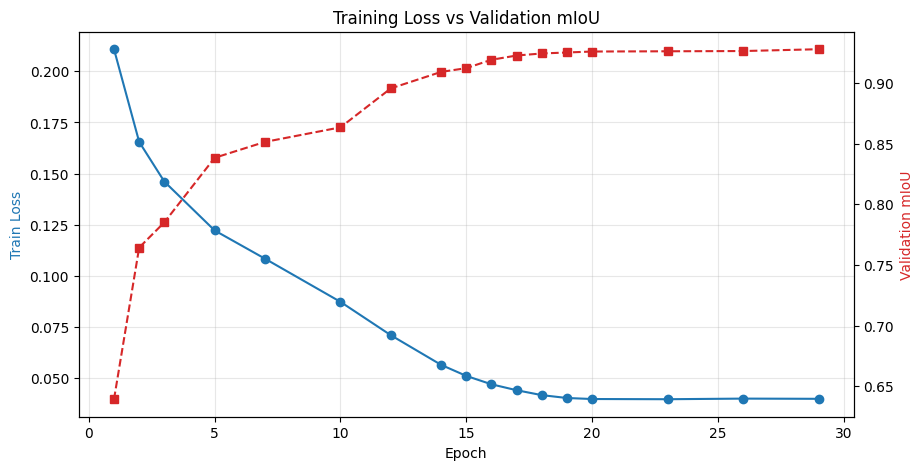